In [ ]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32, 3)
 
def read_trainset_ppm(path, n_labels, resize_to):
    images = []
    labels = []
    
    for i in range(n_labels):
        label_path = path + '/' + format(i, '05d') + '/'
        
        for img_file in glob.glob(label_path + '*.ppm'):
            img = cv2.imread(img_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if resize_to:
                if resize_to[0] < img.shape[0]:
                    img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_AREA)
                else:
                    img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_CUBIC)
            
            label = np.zeros((n_labels, ), np.float32)
            label[i] = 1.0
            
            images.append(img.astype(np.float32))
            labels.append(label)
    
    x_train = np.array(images, np.float32)
    y_train = np.array(labels, np.float32)
    
    return x_train, y_train
 
def read_testset_ppm(path, resize_to):
    images = []
    labels = []
    
    for img_file in glob.glob(path + '/*.ppm'):
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if resize_to:
            if resize_to[0] < img.shape[0]:
                img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_AREA)
            else:
                img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation=cv2.INTER_CUBIC)
                
        images.append(img.astype(np.float32))
    
    
    labels_path = path + '/GT-final_test.csv'
    annotations = pd.read_csv(labels_path, sep=';')
    
    x_testset = np.array(images, np.float32)
    y_testset = tf.one_hot(annotations['ClassId'], depth=N_CLASSES).numpy()
    
    return x_testset, y_testset

In [ ]:
x_train_orig, y_train_orig = read_trainset_ppm('C:/Users/sohnc/0 JupyterPractice/ex1/GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
x_test_orig, y_test_orig = read_testset_ppm('C:/Users/sohnc/0 JupyterPractice/ex1/GTSRB/Final_Test/Images', RESIZED_IMAGE)

In [ ]:
print(x_train_orig.shape)
print(y_train_orig.shape)
print(x_test_orig.shape)
print(y_test_orig.shape)

(39209, 32, 32, 3)
(39209, 43)
(12630, 32, 32, 3)
(12630, 43)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


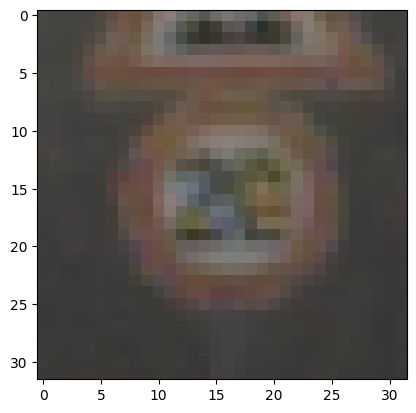

In [ ]:
plt.imshow(x_train_orig[150].astype(np.uint32))
print(y_train_orig[150])

In [ ]:
# set train and val set
from sklearn.model_selection import train_test_split
idx_train, idx_val = train_test_split(range(x_train_orig.shape[0]), test_size=0.2, random_state=101)
X_train = x_train_orig[idx_train,:,:,:]
y_train = y_train_orig[idx_train,]
X_val = x_train_orig[idx_val,:,:,:]
y_val = y_train_orig[idx_val,]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(31367, 32, 32, 3)
(31367, 43)
(7842, 32, 32, 3)
(7842, 43)


In [ ]:
# normalization
X_train /= 255.
X_val /= 255.

In [ ]:
def model1(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                             kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                             kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

In [ ]:
m1 = model1()
m1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h1 = m1.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [ ]:
m1.evaluate(X_val, y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.0759 - accuracy: 0.9874 - recall: 0.9857 - precision: 0.9890


[0.07589692622423172,
 0.9873756766319275,
 0.9857179522514343,
 0.9889969229698181]

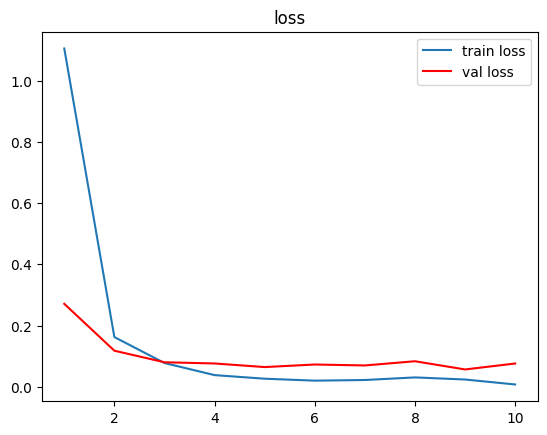

In [ ]:
epochs = [i for i in range(1, len(h1.history['accuracy']) + 1)]
plt.plot(epochs, h1.history['loss'], label='train loss')
plt.plot(epochs, h1.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

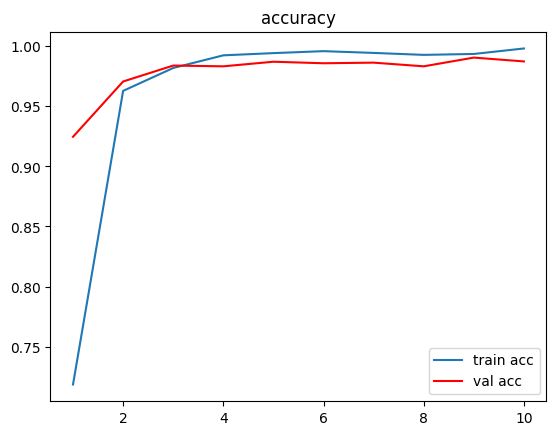

In [ ]:
epochs = [i for i in range(1, len(h1.history['accuracy']) + 1)]
plt.plot(epochs, h1.history['accuracy'], label='train acc')
plt.plot(epochs, h1.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

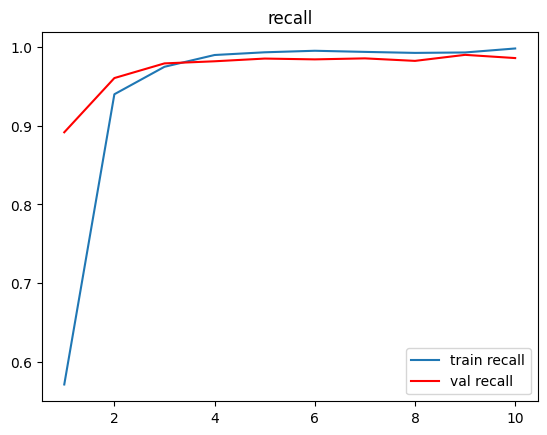

In [ ]:
epochs = [i for i in range(1, len(h1.history['accuracy']) + 1)]
plt.plot(epochs, h1.history['recall'], label='train recall')
plt.plot(epochs, h1.history['val_recall'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

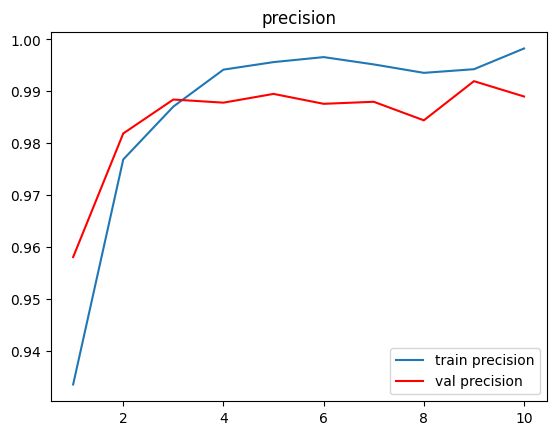

In [ ]:
epochs = [i for i in range(1, len(h1.history['accuracy']) + 1)]
plt.plot(epochs, h1.history['precision'], label='train precision')
plt.plot(epochs, h1.history['val_precision'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()

In [ ]:
# model 2
# batch_size: 256 >> 64
m2 = model1()
m2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h2 = m2.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)             

In [ ]:
m2.evaluate(X_val, y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.1028 - accuracy: 0.9887 - recall_1: 0.9885 - precision_1: 0.9892


[0.10282453149557114,
 0.9886508584022522,
 0.9885233640670776,
 0.989154040813446]

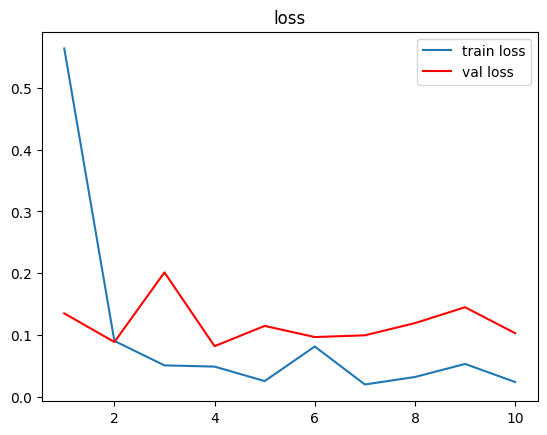

In [ ]:
epochs = [i for i in range(1, len(h2.history['accuracy']) + 1)]
plt.plot(epochs, h2.history['loss'], label='train loss')
plt.plot(epochs, h2.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

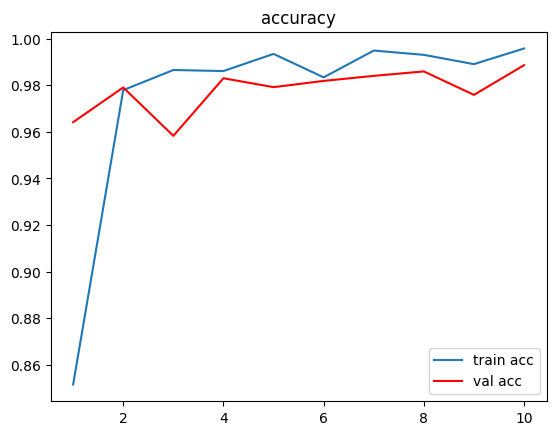

In [ ]:
epochs = [i for i in range(1, len(h2.history['accuracy']) + 1)]
plt.plot(epochs, h2.history['accuracy'], label='train acc')
plt.plot(epochs, h2.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

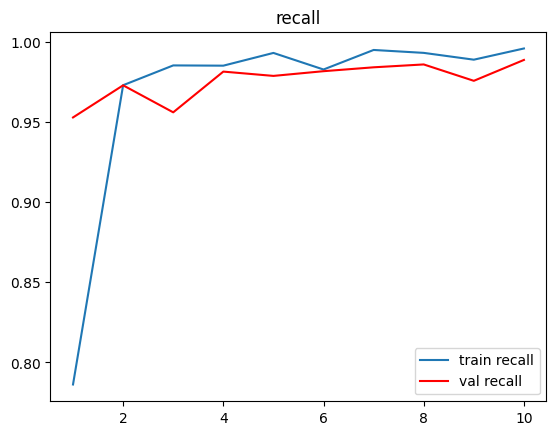

In [ ]:
epochs = [i for i in range(1, len(h2.history['accuracy']) + 1)]
plt.plot(epochs, h2.history['recall_1'], label='train recall')
plt.plot(epochs, h2.history['val_recall_1'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

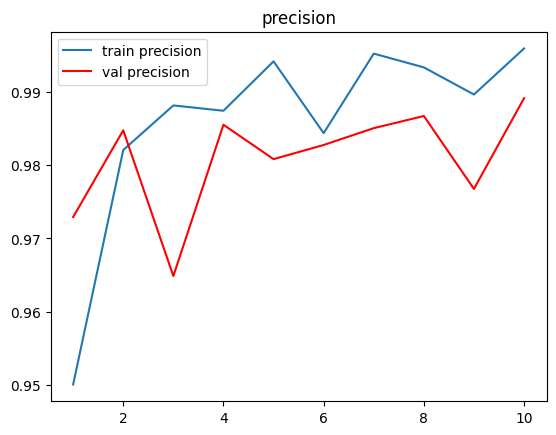

In [ ]:
epochs = [i for i in range(1, len(h2.history['accuracy']) + 1)]
plt.plot(epochs, h2.history['precision_1'], label='train precision')
plt.plot(epochs, h2.history['val_precision_1'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()

In [ ]:
# model 3
# learning rate: 0.001 >> 0.01
m3 = model1()
m3.compile(optimizer=tf.keras.optimizers.Adam(0.01),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h3 = m3.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [ ]:
m3.evaluate(X_val, y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.1052 - accuracy: 0.9759 - recall: 0.9735 - precision: 0.9802


[0.10522755980491638,
 0.9758989810943604,
 0.9734761714935303,
 0.9802259802818298]

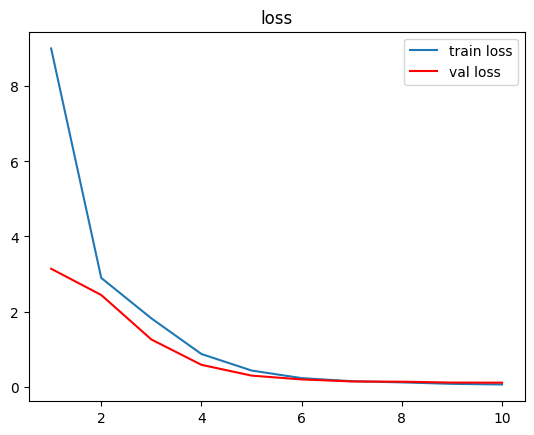

In [ ]:
epochs = [i for i in range(1, len(h3.history['accuracy']) + 1)]
plt.plot(epochs, h3.history['loss'], label='train loss')
plt.plot(epochs, h3.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

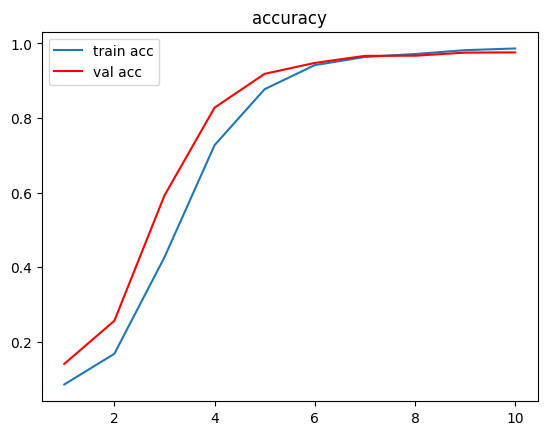

In [ ]:
epochs = [i for i in range(1, len(h3.history['accuracy']) + 1)]
plt.plot(epochs, h3.history['accuracy'], label='train acc')
plt.plot(epochs, h3.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

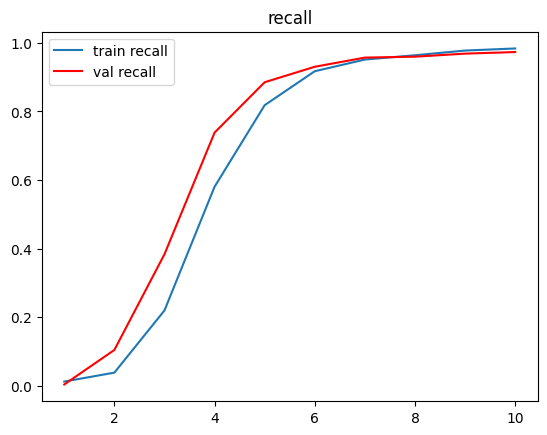

In [ ]:
epochs = [i for i in range(1, len(h3.history['accuracy']) + 1)]
plt.plot(epochs, h3.history['recall'], label='train recall')
plt.plot(epochs, h3.history['val_recall'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

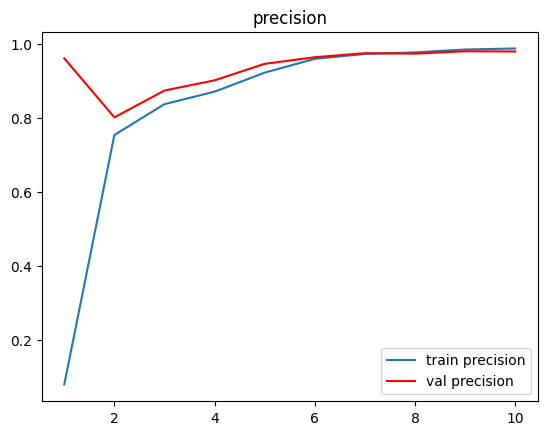

In [ ]:
epochs = [i for i in range(1, len(h3.history['accuracy']) + 1)]
plt.plot(epochs, h3.history['precision'], label='train precision')
plt.plot(epochs, h3.history['val_precision'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()

In [ ]:
def model5(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                             kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                             kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

In [ ]:
# model 5
# dropout: 0 >> 0.25, 0.25

m5 = model5()
m5.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h5= m5.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 64)         

In [ ]:
m5.evaluate(X_val, y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.0619 - accuracy: 0.9906 - recall_1: 0.9899 - precision_1: 0.9917


[0.06193619966506958,
 0.9905636310577393,
 0.9899260401725769,
 0.9916964769363403]

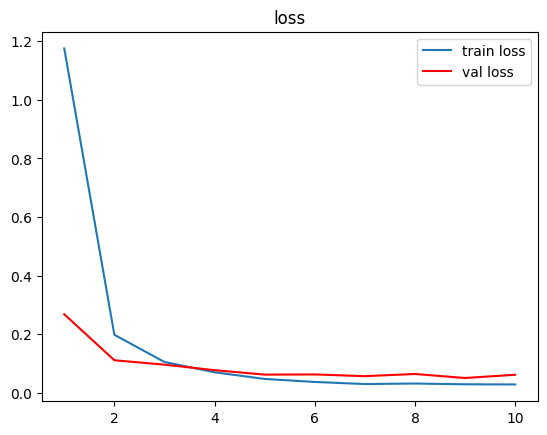

In [ ]:
epochs = [i for i in range(1, len(h5.history['accuracy']) + 1)]
plt.plot(epochs, h5.history['loss'], label='train loss')
plt.plot(epochs, h5.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

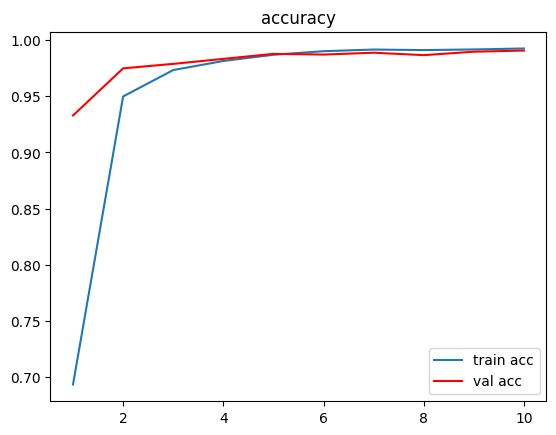

In [ ]:
epochs = [i for i in range(1, len(h5.history['accuracy']) + 1)]
plt.plot(epochs, h5.history['accuracy'], label='train acc')
plt.plot(epochs, h5.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

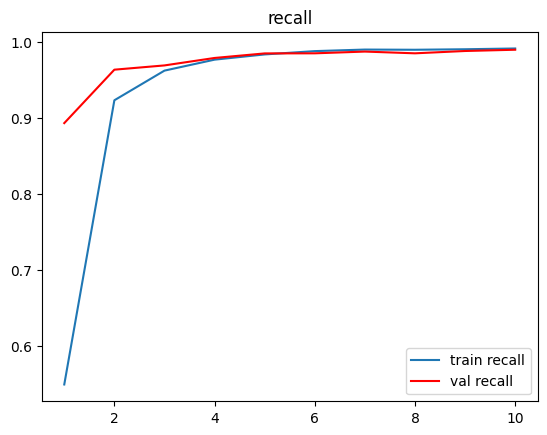

In [ ]:
epochs = [i for i in range(1, len(h5.history['accuracy']) + 1)]
plt.plot(epochs, h5.history['recall_1'], label='train recall')
plt.plot(epochs, h5.history['val_recall_1'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

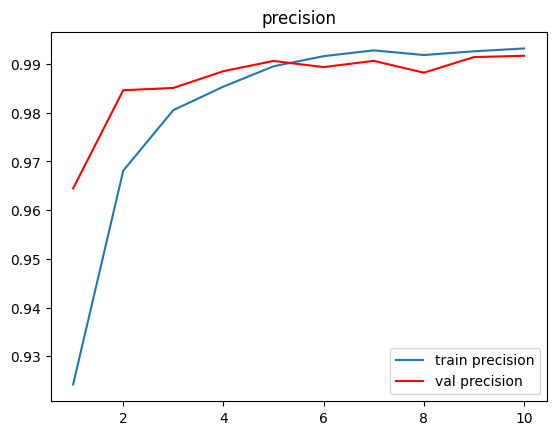

In [ ]:
epochs = [i for i in range(1, len(h5.history['accuracy']) + 1)]
plt.plot(epochs, h5.history['precision_1'], label='train precision')
plt.plot(epochs, h5.history['val_precision_1'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()

In [ ]:
def model6(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                             kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                             kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

In [ ]:
# model 6
# dropout: 0 >> 0.5, 0.5

m6 = model6()
m6.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h6= m6.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)         

In [ ]:
m6.evaluate(X_val, y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.0501 - accuracy: 0.9894 - recall_2: 0.9884 - precision_2: 0.9912


[0.05011535435914993,
 0.9894159436225891,
 0.9883958101272583,
 0.9911764860153198]

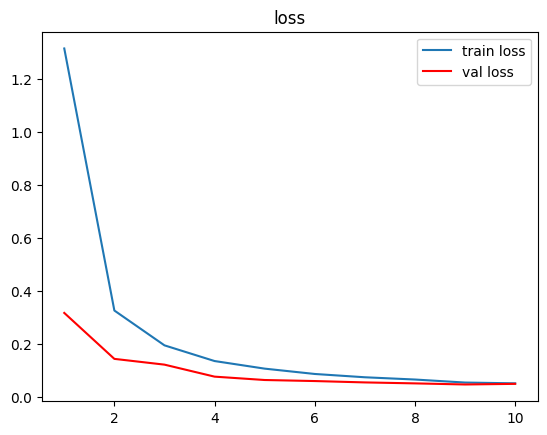

In [ ]:
epochs = [i for i in range(1, len(h6.history['accuracy']) + 1)]
plt.plot(epochs, h6.history['loss'], label='train loss')
plt.plot(epochs, h6.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

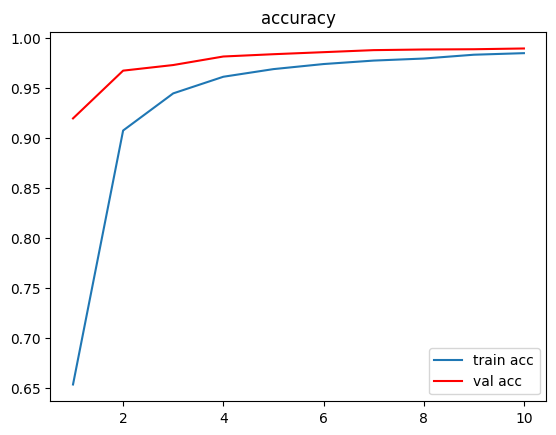

In [ ]:
epochs = [i for i in range(1, len(h6.history['accuracy']) + 1)]
plt.plot(epochs, h6.history['accuracy'], label='train acc')
plt.plot(epochs, h6.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

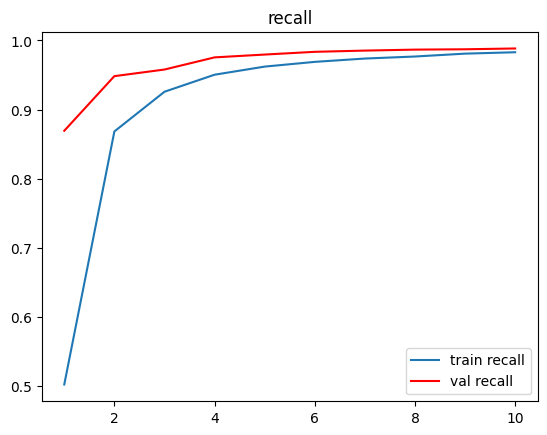

In [ ]:
epochs = [i for i in range(1, len(h6.history['accuracy']) + 1)]
plt.plot(epochs, h6.history['recall_2'], label='train recall')
plt.plot(epochs, h6.history['val_recall_2'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

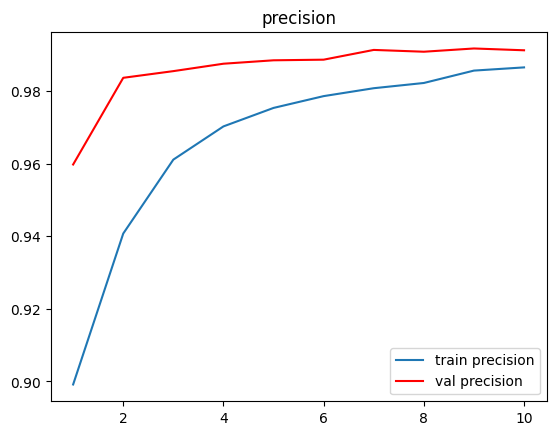

In [ ]:
epochs = [i for i in range(1, len(h6.history['accuracy']) + 1)]
plt.plot(epochs, h6.history['precision_2'], label='train precision')
plt.plot(epochs, h6.history['val_precision_2'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()

In [ ]:
def model7(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.75),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.75),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                             kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                             kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

In [ ]:
# model 7
# dropout: 0 >> 0.75, 0.75

m7 = model7()
m7.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h7= m7.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 64)         

In [ ]:
m7.evaluate(X_val, y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.0693 - accuracy: 0.9830 - recall_3: 0.9790 - precision_3: 0.9860


[0.06927899271249771,
 0.9830400347709656,
 0.9789594411849976,
 0.9860005378723145]

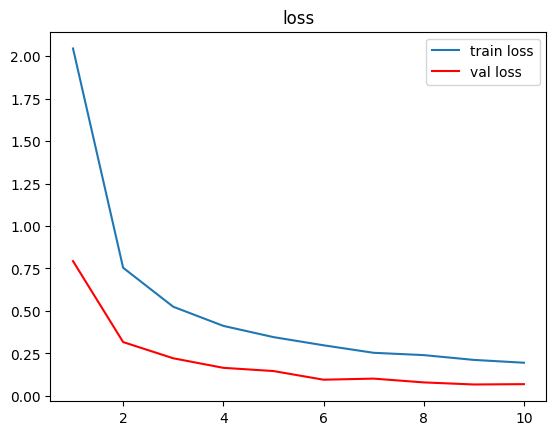

In [ ]:
epochs = [i for i in range(1, len(h7.history['accuracy']) + 1)]
plt.plot(epochs, h7.history['loss'], label='train loss')
plt.plot(epochs, h7.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

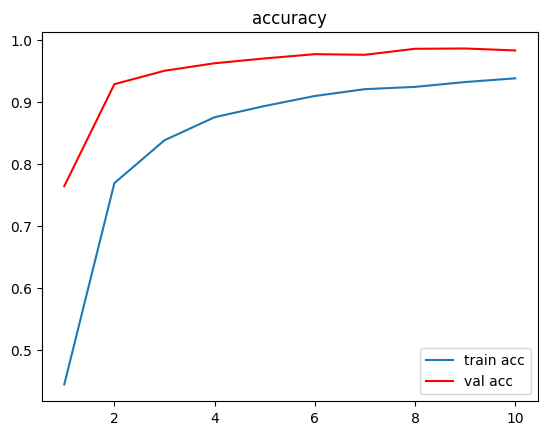

In [ ]:
epochs = [i for i in range(1, len(h7.history['accuracy']) + 1)]
plt.plot(epochs, h7.history['accuracy'], label='train acc')
plt.plot(epochs, h7.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

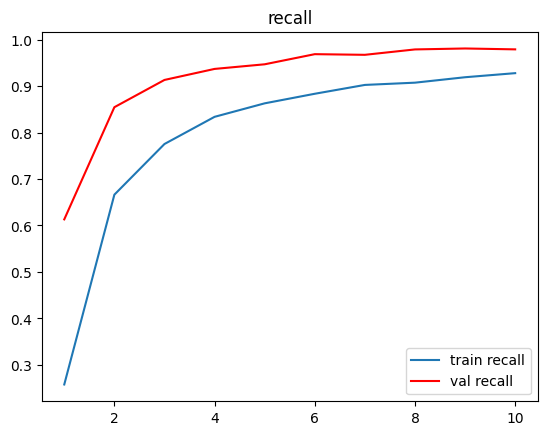

In [ ]:
epochs = [i for i in range(1, len(h7.history['accuracy']) + 1)]
plt.plot(epochs, h7.history['recall_3'], label='train recall')
plt.plot(epochs, h7.history['val_recall_3'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

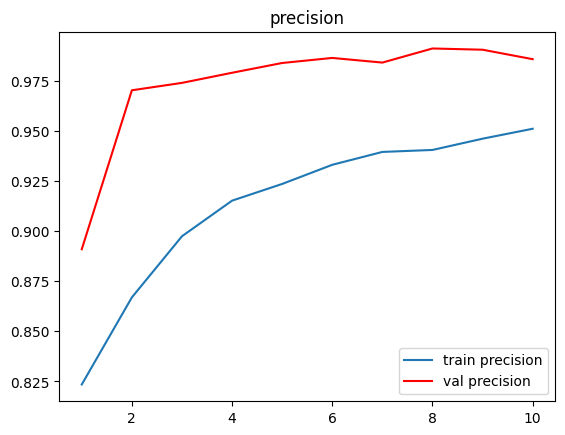

In [ ]:
epochs = [i for i in range(1, len(h7.history['accuracy']) + 1)]
plt.plot(epochs, h7.history['precision_3'], label='train precision')
plt.plot(epochs, h7.history['val_precision_3'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()

In [ ]:
def model8(input_shape=(32, 32, 3)):
    tf.random.set_seed(8)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),
                              kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu',
                             kernel_initializer=tf.keras.initializers.glorot_uniform()),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax',
                             kernel_initializer=tf.keras.initializers.glorot_uniform())
    ])
    
    model.summary()
    return model

In [ ]:
# model 8
# layer: Conv2D,MaxPooling2D 두 레이어 제거


m8 = model8()
m8.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss='categorical_crossentropy',
          metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
h8= m8.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              6423552   
                                                                 
 dense_11 (Dense)            (None, 43)                44075     
                                                                 
Total params: 6,470,059
Trainable params: 6,470,059
Non-trainable params: 0
____________________________________________

In [ ]:
m8.evaluate(X_val, y_val)

246/246 [==============================] - 1s 5ms/step - loss: 0.0795 - accuracy: 0.9847 - recall_5: 0.9830 - precision_5: 0.9880


[0.07951685786247253,
 0.9846977591514587,
 0.9830400347709656,
 0.9879533648490906]

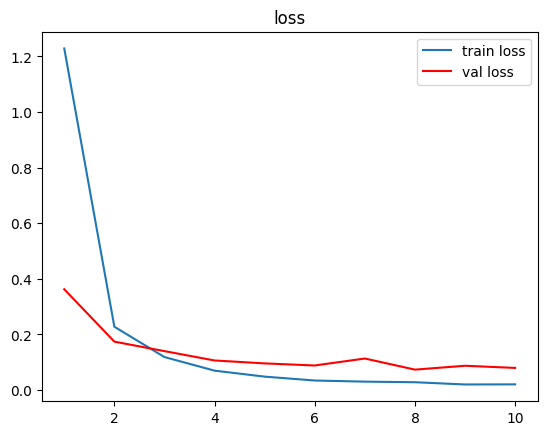

In [ ]:
epochs = [i for i in range(1, len(h8.history['accuracy']) + 1)]
plt.plot(epochs, h8.history['loss'], label='train loss')
plt.plot(epochs, h8.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

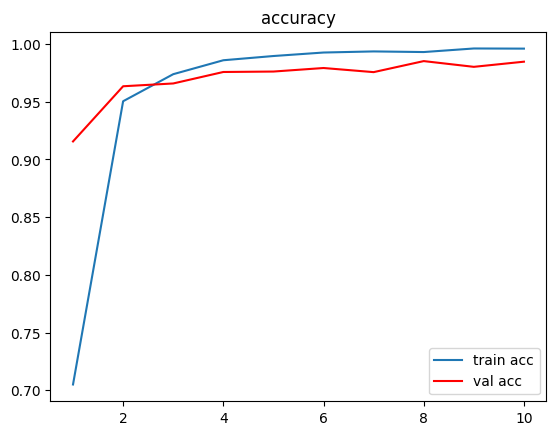

In [ ]:
epochs = [i for i in range(1, len(h8.history['accuracy']) + 1)]
plt.plot(epochs, h8.history['accuracy'], label='train acc')
plt.plot(epochs, h8.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

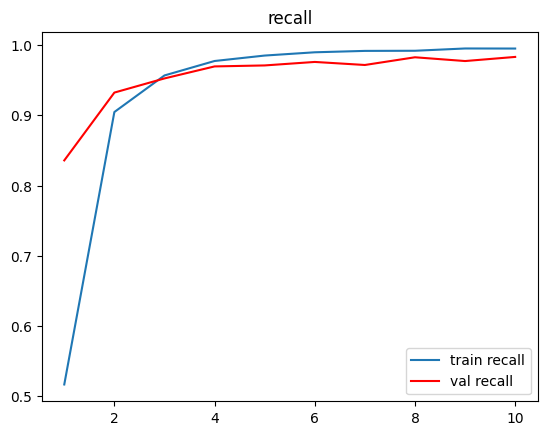

In [ ]:
epochs = [i for i in range(1, len(h8.history['accuracy']) + 1)]
plt.plot(epochs, h8.history['recall_5'], label='train recall')
plt.plot(epochs, h8.history['val_recall_5'], 'r', label='val recall')
plt.title('recall')
plt.legend()
plt.show()

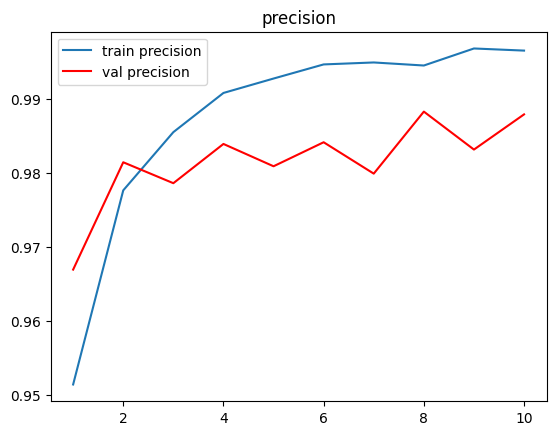

In [ ]:
epochs = [i for i in range(1, len(h8.history['accuracy']) + 1)]
plt.plot(epochs, h8.history['precision_5'], label='train precision')
plt.plot(epochs, h8.history['val_precision_5'], 'r', label='val precision')
plt.title('precision')
plt.legend()
plt.show()